In [ ]:
#Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from datetime import datetime

plt.style.use('ggplot')

#What is stationarity

>A timeseries is said to be stationary if its statistical properties such as mean, variance and covarience remain constant over time. Thus, time series with trends, or with seasonality, are not stationary.

#Why is it important?
1. An underlying assumption in timeseries analysis is that if a timeseries exhibits a particular behaviour over time, there is a very high likelyhood that it will follow the same in the future too.

2. Most of the timeseries models assume that given timeseries is stationary.

3. Most time series forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors. Undelying assumption in Linear regression is that predictors (X variables) are not correlated (multicollinearity). Therefore, stationarising a timeseries solves collinearity problem, since it removes any persistent autocorrelation (more about this in the next section).

#Identifying stationary timeseries

Stationarity is defined using very strict criterion. However, in practice a timeseries is said to be stationary if it has constant statistical properties such as mean, variance and autocovariance over time.

1. The mean of a time series should be a constant. The series on the right has trend (increasing mean), so it is non-stationary.

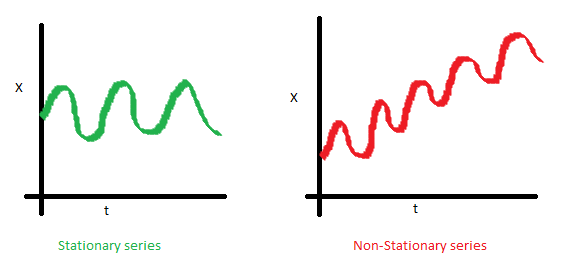

2. The variance of the series should be constant (homoscedasticity). The series on the right has increasing varience, making it non-sationary.

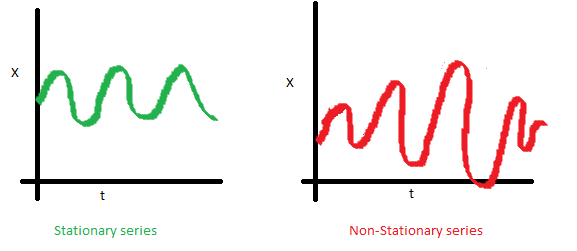

3. Autocovariance of timeseries (i.e., autocorrelation between *i* th term and the *(i + m)* th term) should be constant. The series on the right has decreasing spread with increasing time, so the covariance is not constant with time making it non-stationary.

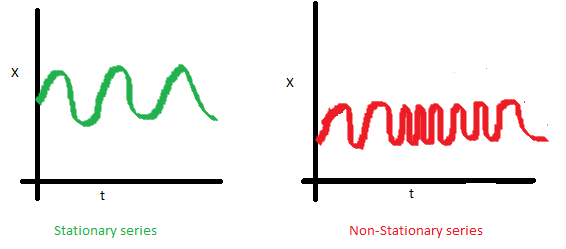

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. Similarly, a white noise series is stationary.

#Can stationarity be identified by visual inspection?

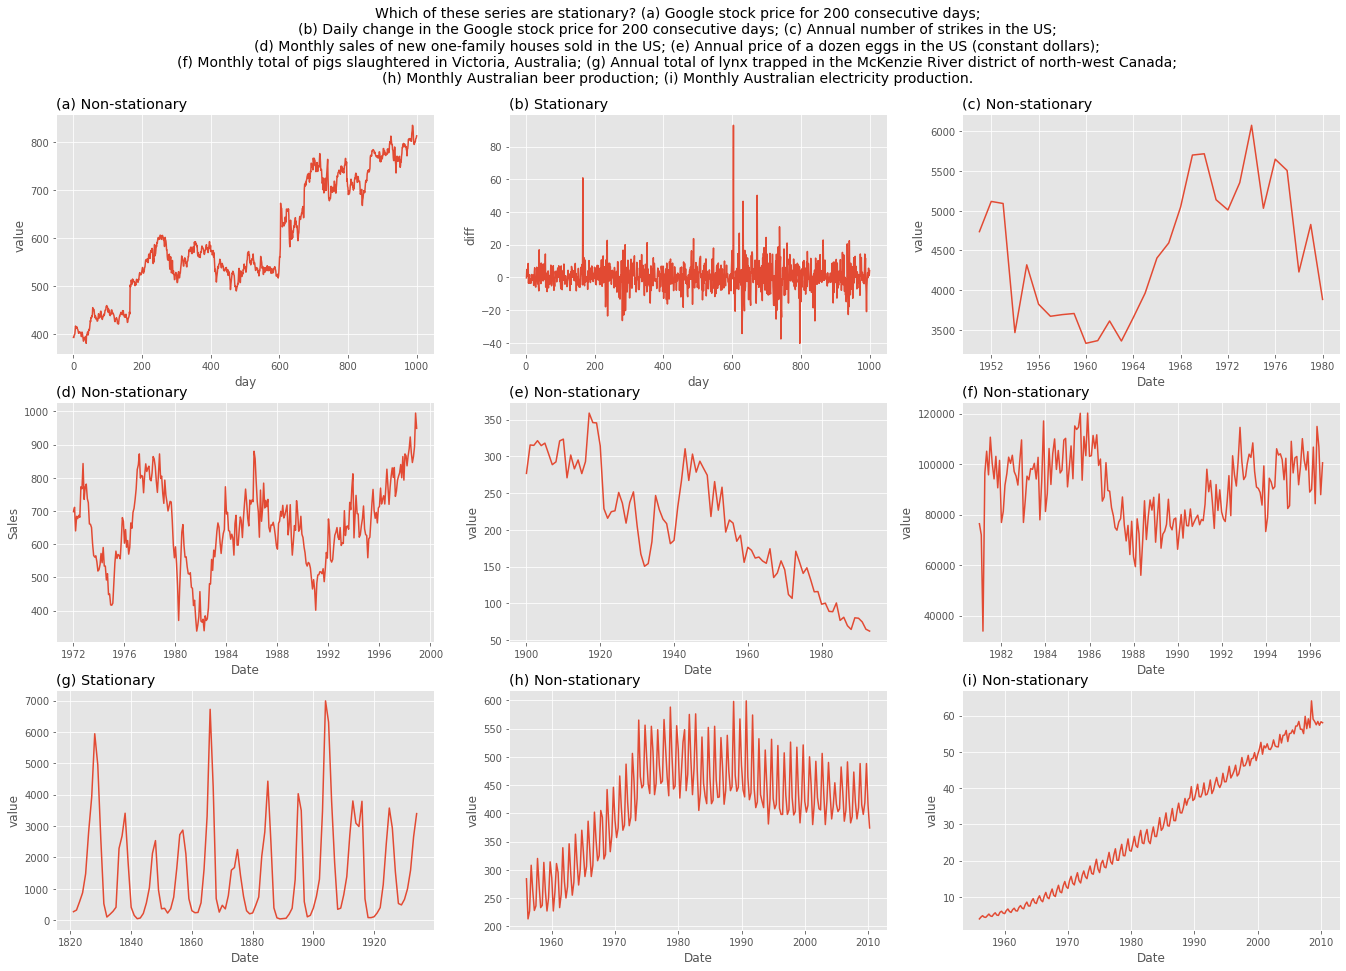

In [ ]:
dt_parser = lambda x: pd.to_datetime(x, format='%d/%m/%Y', errors='coerce')
df1 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/goog.csv', index_col='day')
df1['value1'] = df1.shift(1)
df1['diff'] = df1.value - df1.value1;
df3 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/strikes.csv', parse_dates=['Date'], index_col='Date')
df4 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/HSN1F.csv', parse_dates=['Date'], index_col='Date', date_parser=dt_parser)
df5 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/eggs.csv', parse_dates=['Date'], index_col='Date')
df6 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/pigs.csv', parse_dates=['Date'], index_col='Date', date_parser=dt_parser)
df7 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/LYNX.csv', parse_dates=['Date'], index_col='Date')
df8 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/ausbeer.csv', parse_dates=['Date'], index_col='Date', date_parser=dt_parser)
df9 = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/qauselec.csv', parse_dates=['Date'], index_col='Date', date_parser=dt_parser)

fig, ax = plt.subplots(3, 3, figsize=(23,15))
sn.lineplot(x='day', y='value', data=df1, ax=ax[0,0]).set_title('(a) Non-stationary', loc='left')
sn.lineplot(x='day', y='diff', data=df1, ax=ax[0,1]).set_title('(b) Stationary', loc='left')
sn.lineplot(x='Date', y='value', data=df3, ax=ax[0,2]).set_title('(c) Non-stationary', loc='left')
sn.lineplot(x='Date', y='Sales', data=df4, ax=ax[1,0]).set_title('(d) Non-stationary', loc='left')
sn.lineplot(x='Date', y='value', data=df5, ax=ax[1,1]).set_title('(e) Non-stationary', loc='left')
sn.lineplot(x='Date', y='value', data=df6, ax=ax[1,2]).set_title('(f) Non-stationary', loc='left')
sn.lineplot(x='Date', y='value', data=df7, ax=ax[2,0]).set_title('(g) Stationary', loc='left')
sn.lineplot(x='Date', y='value', data=df8, ax=ax[2,1]).set_title('(h) Non-stationary', loc='left')
sn.lineplot(x='Date', y='value', data=df9, ax=ax[2,2]).set_title('(i) Non-stationary', loc='left');
fig.suptitle('Which of these series are stationary? (a) Google stock price for 200 consecutive days;\n' +
'(b) Daily change in the Google stock price for 200 consecutive days; (c) Annual number of strikes in the US;\n' +
'(d) Monthly sales of new one-family houses sold in the US; (e) Annual price of a dozen eggs in the US (constant dollars);\n' + 
'(f) Monthly total of pigs slaughtered in Victoria, Australia; (g) Annual total of lynx trapped in the McKenzie River district of north-west Canada;\n' +
'(h) Monthly Australian beer production; (i) Monthly Australian electricity production.', fontsize=14);

#Statistical tests for stationarity

It is not easy to establish a given time series is stationary or non-stationary by visual inspection alone. Stationarity check can be performed using the following approaches:

**Plotting Rolling Statistics**: We can plot the moving average and/or moving variance and see if it varies with time. But again this is more of a visual technique.

**Unit Root tests**: To identify a stationary time series a number of tests called Unit Root tests available, which are based on different assumptions and may lead to conflicting answers. Some of these tests include:

1. Augmented Dickey Fuller test (ADF Test)
2. Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
3. Philips Perron test (PP Test)

In this work ADF and KPSS tests are used. 

>In **ADF test**, the null hypothesis is that the data are **non-stationary**, and we look for evidence that the null hypothesis is false. Consequently, small p-values (e.g., less than 0.05) suggest that timeseies is **stationary**.

>In **KPSS test**, the null hypothesis is that the data are **stationary**, and we look for evidence that the null hypothesis is false. Consequently, small p-values (e.g., less than 0.05) suggest that timeseries is **non-stationary**.

To check stationarity of a timeseries, rolling statistics plots along with Unit Root test results will be used. A function which takes a timeseries as input and generate the above information is developed. Please note standard deviation is plotted instead of variance to keep the units similar as mean.



In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

def check_stationarity(ts, window=12, reg='c'):
    warnings.filterwarnings("ignore")

    #Calculate rolling statistics over 1 year period
    rolling_mean = ts.rolling(window).mean()
    rolling_std = ts.rolling(window).std()

    #Plot rolling statistics
    plt.figure(figsize=(15,5))
    plt.plot(ts, color='blue', label='timeseries')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label = 'Rolling Std')
    plt.legend()
    plt.title('Plot of Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Calculate Augmented Dickey-Fuller statistic:
    print('\n\nResults of Augmented Dickey-Fuller & KPSS Tests:')
    adf = adfuller(ts, autolag='AIC')
    ds1 = pd.Series(adf[0:3], index=['Test Statistic','p-value','#Lags Used'], name='ADF')
    for key, value in adf[4].items():
        ds1['Critical Value (%s)'%key] = value
    ds1['Type of series'] = 'Stationary' if adf[1] < 0.05 else 'Non-stationary'
    
    #Calculate KPSS statistic:
    kps = kpss(ts, regression=reg, lags='auto')
    ds2 = pd.Series(kps[0:3], index=['Test Statistic','p-value','#Lags Used'], name='KPSS')
    for key, value in kps[3].items():
        ds2['Critical Value (%s)'%key] = value
    ds2['Type of series'] = 'Non-stationary' if kps[1] < 0.05 else 'Stationary'

    df = pd.concat([ds1, ds2], axis=1)
    print(df.iloc[:-1])

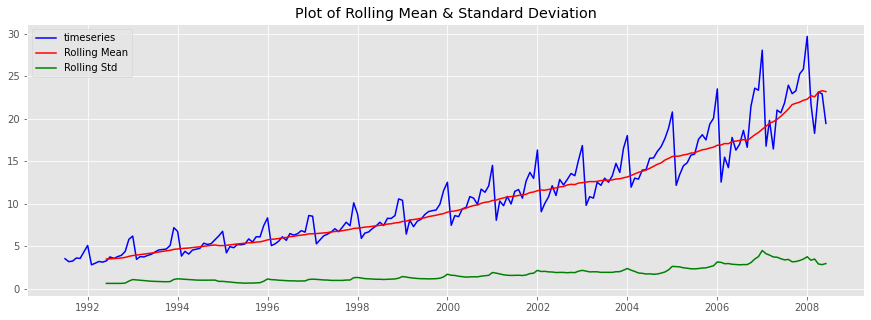



Results of Augmented Dickey-Fuller & KPSS Tests:
                                 ADF            KPSS
Test Statistic               3.14519         2.01313
p-value                            1            0.01
#Lags Used                        15               9
Critical Value (1%)         -3.46562           0.739
Critical Value (5%)         -2.87704           0.463
Critical Value (10%)        -2.57503           0.347
Type of series        Non-stationary  Non-stationary


In [ ]:
dt_parser = lambda x: pd.to_datetime(x, format='%d/%m/%Y', errors='coerce')
df_drug = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/a10.csv', parse_dates=['Date'], index_col='Date', date_parser=dt_parser)

check_stationarity(df_drug.value, 12);

#How to make a non-stationary timeseries stationary
More often than not, time series data are *non-stationary*. Although, many statistical approaches were proposed to convert a *non-stationary* series to *stationary*, making a series perfectly *stationarity* is impossible.

###What is making a timeseries non-stationary?
>There are mainly two reasons for non-stationarity of a timeseries:
1. **Trend** – changing mean over time.
2. **Seasonality** – changing variance and autocovariance.

###What methods are available for making a timesereis stationary?
>Theare are a number of approaches, however, the following three appraches are frequently used.
1. **Non-stationarity in mean - Deterministic trend models:** If a series exhibits level shifts (ie change in intercept) the appropriate remedy to make the series stationary is to "demean" the series.
2. **Non-stationarity in variance and autocovariance - transformations:** A timeseries that is stationary in the mean is not necessarily stationary in the variance and the autocovariance. In such situations mean stabilisation could be achieved by applying transformations.
3. **Non-stationarity in mean and variance - Differencing methods:** A homogeneous nonstationary timeseries can be reduced to a stationary timeseries by tak­ing a proper degree of differencing.


**Note:** Sometimes adjusting for the mean-shift is sufficient, in some situations transformation of timeseries may make a timeseries stationary, and very often differencing is appropriate to make a timeseries stationary. occationally, we may have to apply more than one technique (e.g., transformation + differencing)

The following paragraphs explain some of the frequently used approaches to make a timeseries *stationary*.

##1. Non-stationarity in mean - Deterministic trend models
>If the mean level of the timeseries is a pure deterministic function of time, we characterise the timeseries as having a deterministic trend. 

The mean function of a nonstationary process could be represented by a deterministic trend of time. In such a case, a standard regression model might be used to describe the phenomenon. These models can be analyzed using standard regression analysis.

##2. Non-stationarity in variance and autocovariance - transformations 
Not all non-stationary series can be transformed to stationary series by differencing. A process that is stationary in the mean is not necessarily stationary in the variance and the autocovariance. Many timeseries are stationary in the mean but are nonstationary in the variance. To overcome this problem, we need a proper variance stabilizing transformation. 

Some important points to remember before applying transformations:
1.	The variance stabilizing transformations introduced above are defined only for positive series. This definition, however, is not as restrictive as it seems because a constant can always be added to the series without affecting the correlation structure of the series.

2.	A variance stabilizing transformation, if needed, should be performed before any other analysis such as differencing.

3.	Frequently, the transformation not only stabilizes the variance, but also improves the approximation of the distribution by a normal distribution.

##3. Non-stationarity in mean and variance - Differencing methods
>If the mean level of the timeseries changes through time stochastically, we characterise the timeseries as having a stochastic trend.

A homogeneous nonstationary timeseries can be reduced to a stationary timeseries by tak­ing a proper degree of differencing.

In [ ]:
dt_parser = lambda x: pd.to_datetime(x, format='%d/%m/%Y', errors='coerce')
df = pd.read_csv('https://raw.githubusercontent.com/tdevip/TSA/master/data-raw/usmwunemployment.csv', parse_dates=['Date'], index_col='Date', date_parser=dt_parser)

check_stationarity(df.value, 12);